---- 
# Problem 3
----

For this problem, you will need to leverage your work on water bacteria detection. As described
before, Water is usually formed by small pollution particles and some bacteria. However, the
presence of big quantities of certain types of bacteria should turn on the alarms. Specifically,
you will need to detect a different type of bacteria by compression algorithms, morphological
algorithms and so on. This time, you will need to work with an image dataset from Google
Dataset Search (https://datasetsearch.research.google.com/).
To submit your answer to this problem, you must use an independent ipynb file and a python file
capable of accepting an image input and then showing a result.



To solve this exercise we used a dataset called "Bacteria detection with darkfield microscopy" uploaded by Long Nguyen on the Kaggle platform, the link is as follows: (https://www.kaggle.com/longnguyen2306/bacteria-detection-with-darkfield-microscopy?select=images). From this dataset we extracted the images that in my opinion could be processed in a better way with the methods learned so far in this evaluation. Additionally, 30% of the images in the dataset were edited so that the number of bodies present in the image was kept to a minimum and we could emulate a relatively clean microscopic view of water. In total, I will use a dataset consisting of 60 images in total, which, given that no machine learning techniques are being used, is considered sufficient to test the performance of the developed code.

----
## Load the images to the working space
----

The images will then be loaded into the working environment so that you can work with them.

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, requests
from sklearn.decomposition import PCA

!unzip 'Problem3'

filenames = []
images = []
images_gray = []

for filename in os.listdir('dataset_bacteria/'):
  filenames.append(filename)
  image = cv2.imread("dataset_bacteria/"+filename)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  # Apply Median Blur for removing some noise
  image = cv2.medianBlur(image , 5)
  image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  images.append(image)
  images_gray.append(image_gray)

images = np.array(images)

print('Total Number of Bacteria Images:', len(images))
print(images.shape)

Archive:  Problem3.zip
replace dataset_bacteria/001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset_bacteria/001.png  
  inflating: dataset_bacteria/025.png  
  inflating: dataset_bacteria/043.png  
  inflating: dataset_bacteria/091.png  
  inflating: dataset_bacteria/096.png  
  inflating: dataset_bacteria/099.png  
  inflating: dataset_bacteria/107.png  
  inflating: dataset_bacteria/108.png  
  inflating: dataset_bacteria/113.png  
  inflating: dataset_bacteria/116.png  
  inflating: dataset_bacteria/117.png  
  inflating: dataset_bacteria/118.png  
  inflating: dataset_bacteria/121.png  
  inflating: dataset_bacteria/122.png  
  inflating: dataset_bacteria/123.png  
  inflating: dataset_bacteria/125.png  
  inflating: dataset_bacteria/129.png  
  inflating: dataset_bacteria/130.png  
  inflating: dataset_bacteria/131.png  
  inflating: dataset_bacteria/135.png  
  inflating: dataset_bacteria/136.png  
  inflating: dataset_bacteria/168.png  
  inflating: dataset_ba

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Four random images from the dataset will be displayed. The indexes will be saved in a list for further work with the same four images.

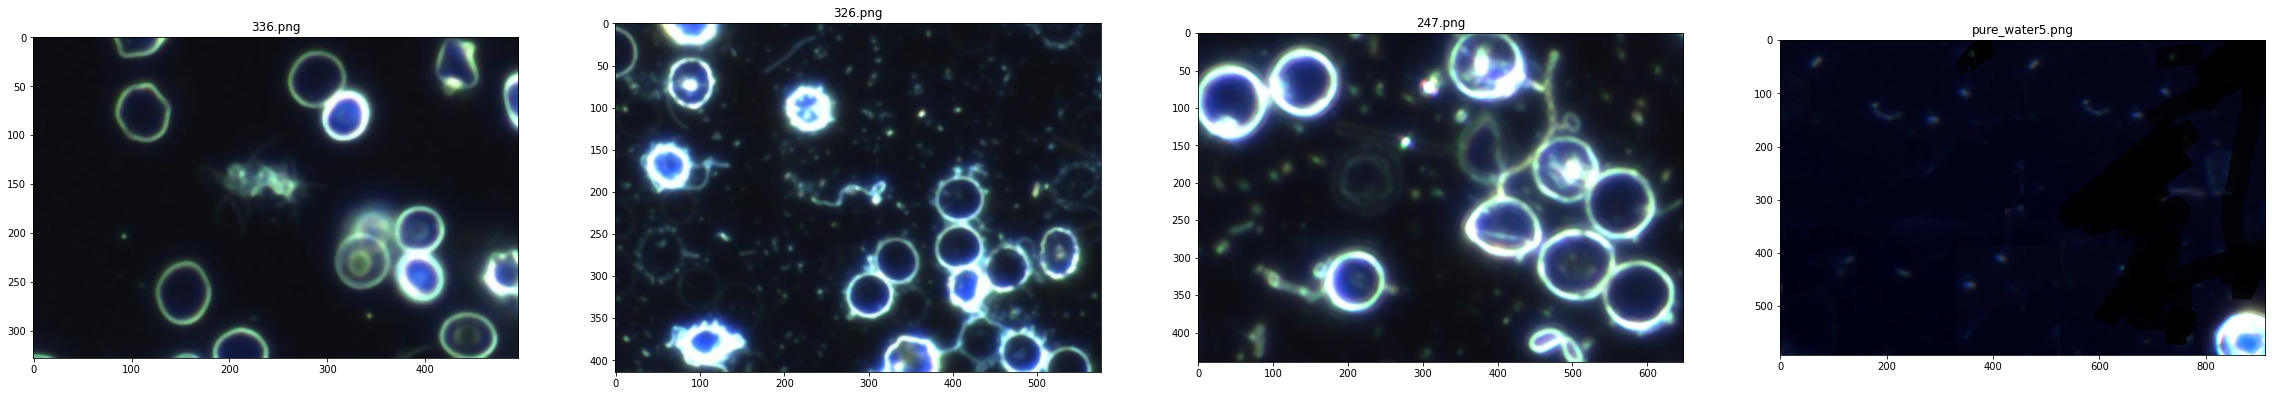

In [27]:
num_images = 4
list_index = []

plt.figure(figsize=(40, 20))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    index = np.random.choice(range(len(images)))
    list_index.append(index)
    image = images[index]
    filename=filenames[index]
    plt.imshow(image, 'gray')
    plt.title(filename)

The same four images are shown in greyscale.

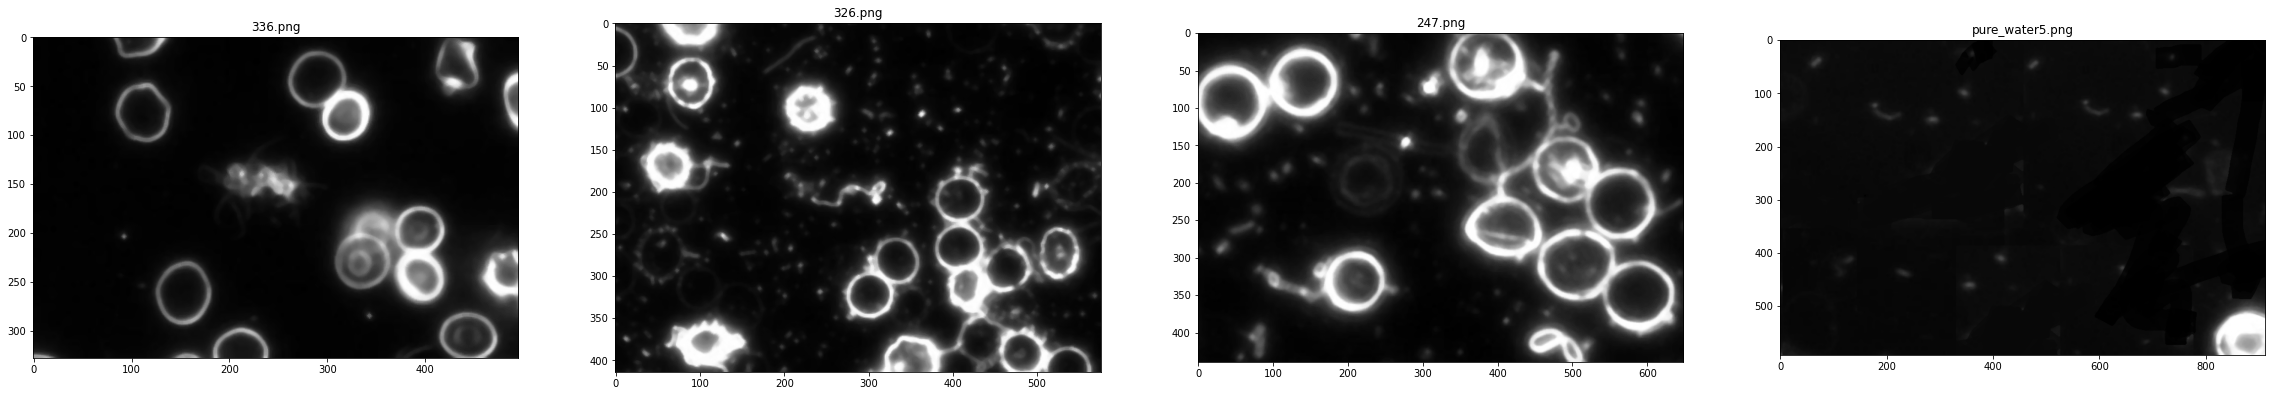

In [28]:
num_images = 4

plt.figure(figsize=(40, 20))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    index = list_index[i]
    image = images_gray[index]
    filename=filenames[index]
    plt.imshow(image, 'gray')
    plt.title(filename)

----
## Pre-processing: Image Compression
----

This algorithm works by reducing the dimensionality of the data, maintaining the most important variables (features) and reducing the redundancies. In this case, as we are dealing with images, we can see the so-called features as the columns of the image, therefore, we can define a compression percentage based on the amount of features that we want to maintain in our image, in this case we will work maintaining 30% of the components for each image.

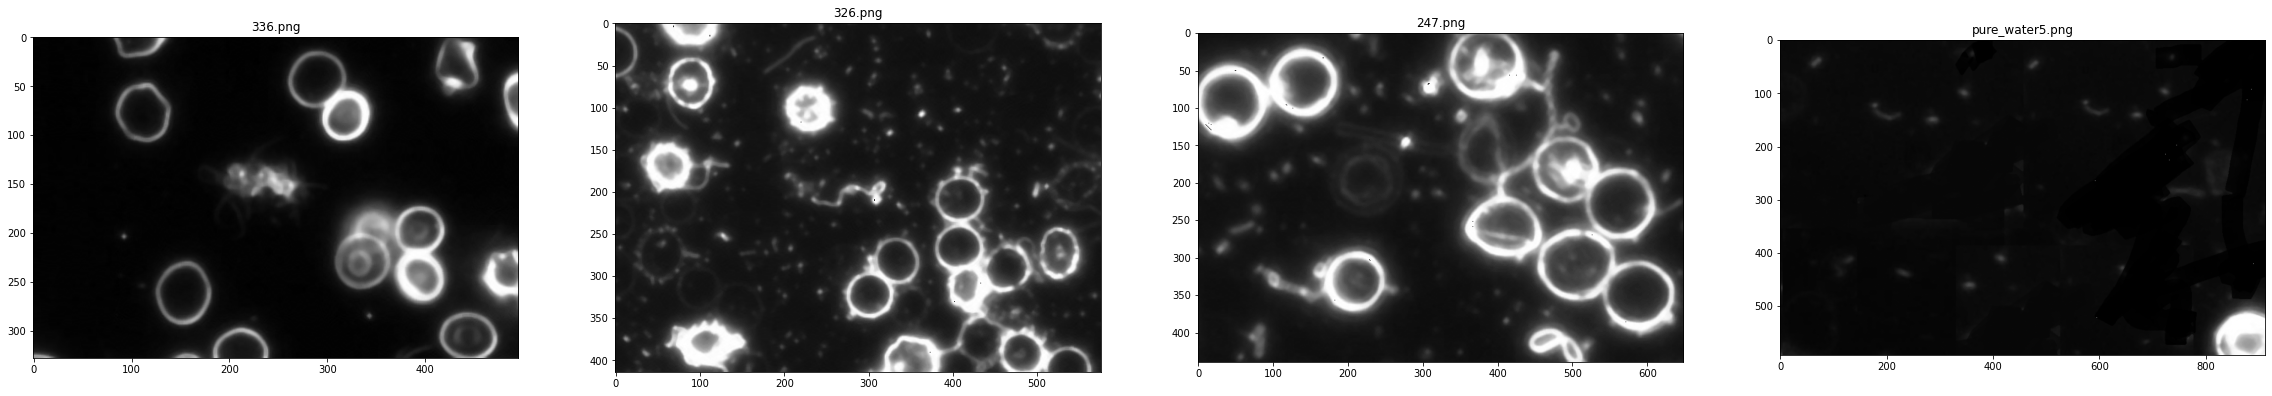

In [29]:
pca_compressed_images = []

num_images = len(images_gray)
# define the custom compression rate for PCA
compression_percentage = 0.3

for i in range(num_images):

  # define the number of components to mantain in order to a compression percentage
  n_comp = int(compression_percentage*images[i].shape[0])
  # Initialize PCA object
  pca = PCA(n_components=n_comp)

  # Standardize the data, so all instances have 0 as the center
  pca.fit(images_gray[i]) 

  # Find the (n_comp) number of principal components and remove the less important 
  # Theres's also another function that joins fit and tranform: pca.Fit_transform()
  principal_components = pca.transform(images_gray[i]) 

  # Since PCA reduces the number of columns, we will need to transform the results 
  # to the original space to display the compressed image
  temp = pca.inverse_transform(principal_components) 
  pca_compressed_images.append(np.uint8(temp))

num_images = 4

plt.figure(figsize=(40, 20))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    index = list_index[i]
    image = pca_compressed_images[index]
    filename=filenames[index]
    plt.imshow(image, 'gray')
    plt.title(filename)

----
## Pre-processing: Morphological operations and edges highlighting
----

At this stage, morphological operations such as erosion, and closing will be used to reduce noise and figures small enough not to be considered. Edge detection using cannyEdge will also be used and a binary threshold will be applied to highlight the edges found. Finally, a dilatation step will be applied to cover the empty spaces between the contours found.

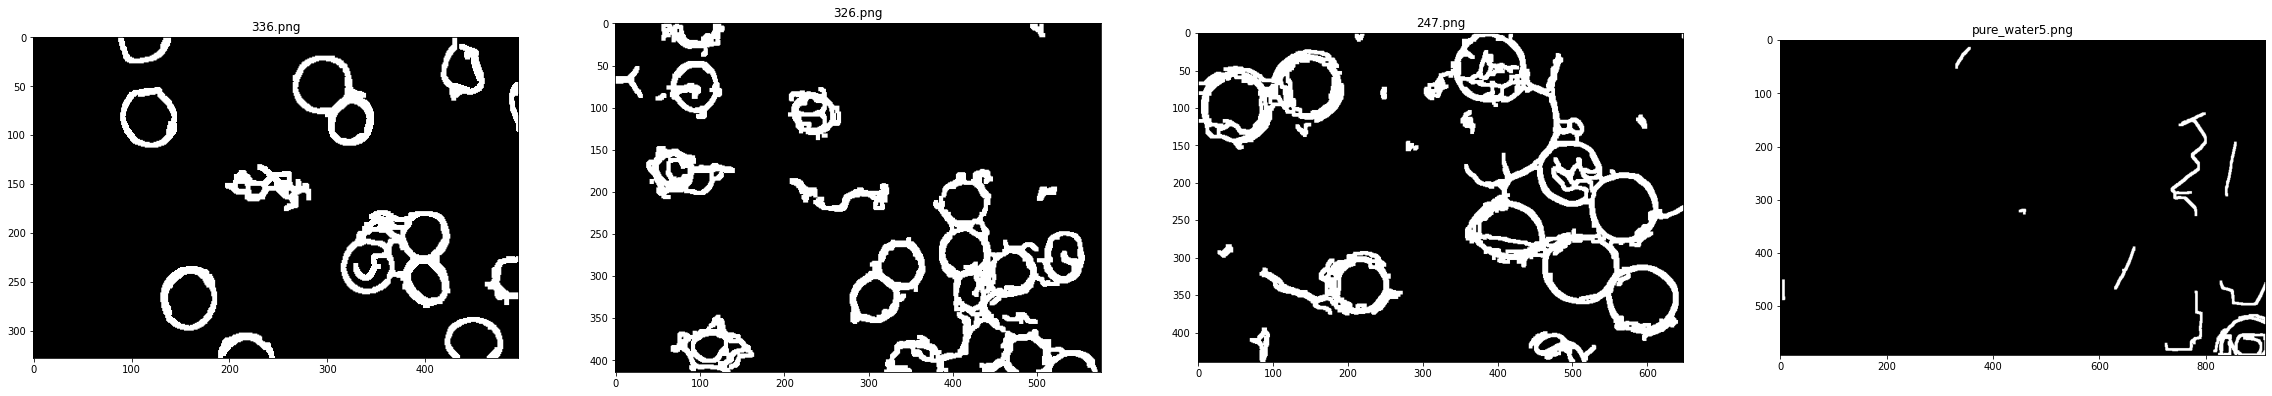

In [30]:
preprocessed_images = []

# Create a 4x4 kernel for morphological process
s = np.ones((2,2),np.uint8)

for morph in pca_compressed_images:
  
  # Apply erotion to reduce noise and small parts
  morph = cv2.erode(morph, s, iterations = 7)
  
  # Apply closing to fill contours
  morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, s, 25)

  # Apply CannyEdge detection
  morph = cv2.Canny(morph, 30, 90)

  # Apply adaptative threshold to highlight contours
  morph = cv2.adaptiveThreshold (morph, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 3, 1)

  # Dilate the contours found
  morph = cv2.dilate(morph, s, iterations = 2)

  preprocessed_images.append(morph)


num_images = 4

plt.figure(figsize=(40, 20))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    index = list_index[i]
    image = preprocessed_images[index]
    filename=filenames[index]
    plt.imshow(image, 'gray')
    plt.title(filename)

As can be seen, some considerable figures were reduced as noise and some contours were filled in by the processing.

----
## Processing: Find contours
----

In this section we will use the findContours module of the OpenCV library to find the most relevant contours of the objects present in the image.

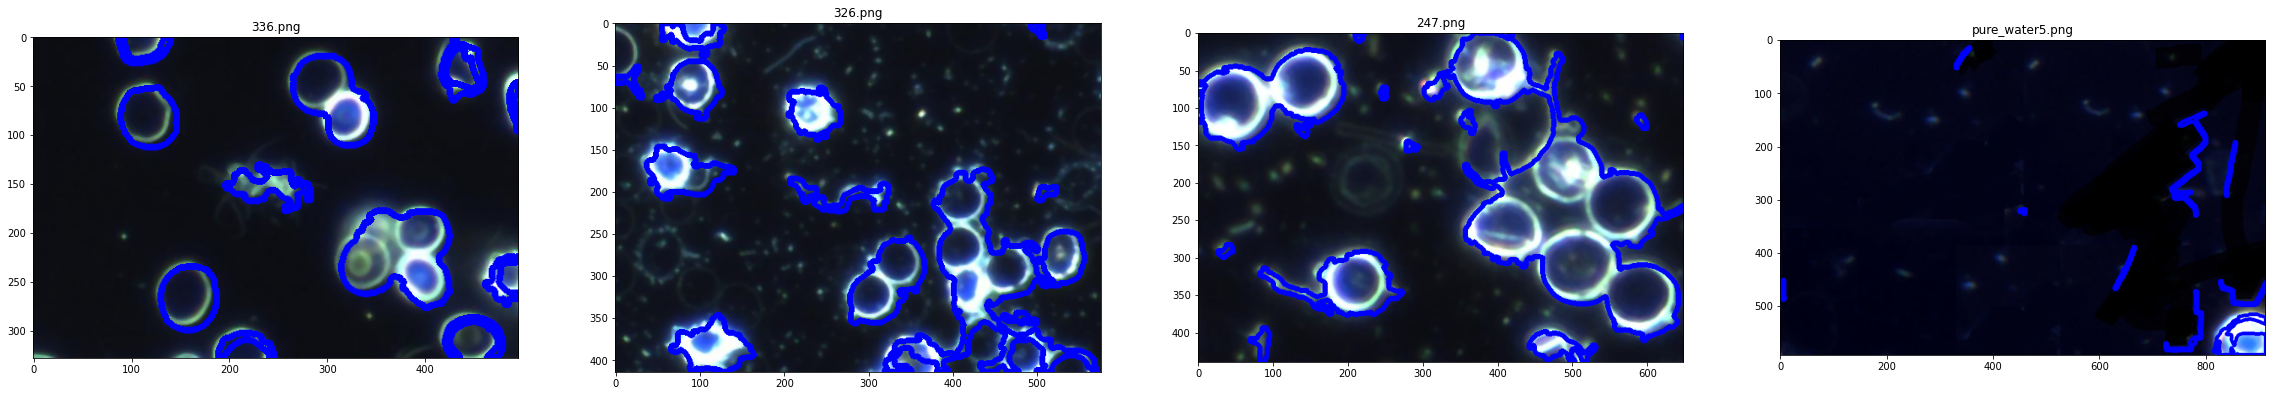

In [31]:
image_contours = []
contours_number = []

for image, preprocessed in zip(images, preprocessed_images):
  # copy the image to avoid overwriting.
  image_copy = np.copy(image)
  # find the contours in the image
  # use cv2.RETR_EXTERNAL to return only extreme outer flags
  contours, _ = cv2.findContours(preprocessed , cv2.RETR_EXTERNAL,  cv2.CHAIN_APPROX_SIMPLE)
  # draw the found contours in the copied image
  cv2.drawContours(image_copy, contours, -1, (0, 0, 255), 5)

  image_contours.append(image_copy)
  contours_number.append(len(contours))

plt.figure(figsize=(40, 20))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    index = list_index[i]
    image = image_contours[index]
    filename=filenames[index]
    plt.imshow(image)
    plt.title(filename)

Now the number of contours found in each of the images you have been working with will be displayed. 

In [32]:
for i in range(num_images):
    index = list_index[i]
    contours = contours_number[index]
    filename=filenames[index]
    print(f'- {contours} contours were found in the image {filename}.')

- 11 contours were found in the image 336.png.
- 13 contours were found in the image 326.png.
- 13 contours were found in the image 247.png.
- 9 contours were found in the image pure_water5.png.


Let's find some statistical measures from the list with the number of contours found.

In [33]:
# Find the median for the contours number list
median = np.median(contours_number)
# Find the average for the contours number list
average = np.mean(contours_number)
print(contours_number)
print(f'The median of contours on the dataset images is: {median}')
print(f'The average of contours on the dataset images is: {median}')

[18, 1, 10, 5, 13, 7, 30, 17, 20, 19, 19, 24, 0, 9, 12, 11, 21, 11, 2, 17, 13, 11, 25, 12, 20, 4, 16, 8, 2, 24, 8, 13, 19, 11, 18, 0, 11, 21, 12, 3, 11, 20, 3, 15, 37, 8, 0, 24, 13, 1, 24, 13, 0, 11, 24, 0, 11, 9, 11, 6]
The median of contours on the dataset images is: 11.5
The average of contours on the dataset images is: 11.5


With the values obtained we can determine a minimum parameter of 11 contours detected to determine that the water is contaminated.

In [34]:
min_contours = 11
flags = []
for contour in contours_number:
    if contour >= min_contours:
      flags.append(True)
    else:
      flags.append(False)

for i in range(num_images):
  index = list_index[i]
  contours = contours_number[index]
  filename = filenames[index]
  flag = flags[index]
  if flag:
    print(f'In the image {filename} were found {contours}, therefore the water is contaminated.')
  else:
    print(f'In the image {filename} were found {contours}, therefore the water is clean.')

In the image 336.png were found 11, therefore the water is contaminated.
In the image 326.png were found 13, therefore the water is contaminated.
In the image 247.png were found 13, therefore the water is contaminated.
In the image pure_water5.png were found 9, therefore the water is clean.


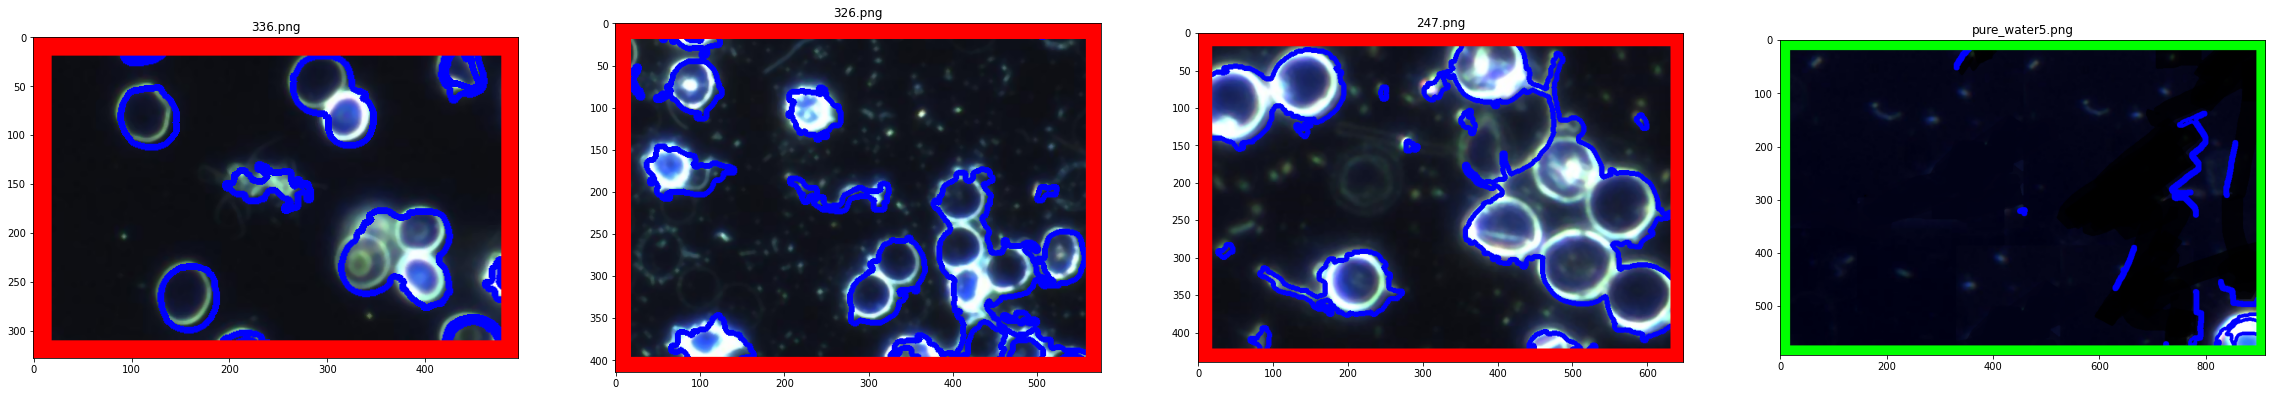

In [35]:
final_images = []
for image, flag in zip(image_contours,flags):
  final_image = np.copy(image)
  w = final_image.shape[0]
  h = final_image.shape[1]
  if (flag):
      cv2.rectangle(final_image, (0, 0), (h, w), (255, 0, 0), 35)
  else:
      cv2.rectangle(final_image, (0, 0), (h, w), (0, 255, 0), 35)
        
  final_images.append(final_image)

plt.figure(figsize=(40, 20))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    index = list_index[i]
    image = final_images[index]
    filename=filenames[index]
    plt.imshow(image)
    plt.title(filename)

A green outline is drawn on the clean water images and a red outline is drawn on the polluted water images.